In [4]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from itertools import combinations as cb

# 1 随机采样阵生成

In [5]:
# 随机采样阵生成
def randSamplingMatrix(m,N):
    """
    Return m*N sampling matrix.
    Use type `np.float32`.
    """
    
    #用高斯分布抽样并单位化.
    A = np.random.randn(m,N).astype(np.float32)
    A = (A/np.sqrt(m)).astype(np.float32)
    return A

# 2 Restricted Isometry Constant 估计

In [13]:
# RIP测试.
class RIPtest:
    def __init__(self,A,s):
        """
        Return possible delta_s given matrix `A` and sparsity `s`.

        Contain 2 methods:
            `RIPtest(A,s).monteCarlo(nVec,show)`: Monte Carlo method;
            `RIPtest(A,s).singularValue()`: singularValue method.
        """
        self.A = A
        self.s = s
    #         
    # 
    # 
    #                 
    # Monte-Carlo method.
    def monteCarlo(self, nVec=1e5, show=True): # 这是一个对象方法.
        # def fun() 是类方法; def fun(self) 是对象方法.
        """
        Return possible delta_s given matrix `A` and sparsity `s`. 
        `nVec`: Number of vectors to test. 
        `show`: Whether to draw the distribution of amplifications.

        Running time:
            O(nVec=10000,N=10000,m=400)~70sec;
            
            O(nVec=5000,N=5000,m=200)~10sec;

            O(nVec=100000,N=200,m=50)~3sec.
        """
        
        N = self.A.shape[1]
        nVec = int(nVec) # 转化形如`1e5`的输入.
        V =  np.zeros((N,nVec),order='F',dtype=np.float32) # 由多个s-稀疏的列向量组成. 
        Supps = np.array([np.random.choice(range(N),self.s,replace=False) for i in range(nVec)])
            # 随机抽取支集, 存为每一行.
        Entries = np.array([np.random.randn(self.s).astype(np.float32) for i in range(nVec)])
            # 随机赋予支集项的值, 存为每一行. 未正规化.
        for j in range(nVec):
            # supp = Supps[j]
            # entries = Entries[j]
            V[Supps[j],j] = Entries[j]/np.linalg.norm(Entries[j])
        V = np.dot(self.A,V)
            # 象.
        Amplifications = np.array(list(map(lambda v:np.linalg.norm(v), np.transpose(V))))
        ampMax = np.max(Amplifications); delta1 = ampMax-1
        ampMin = np.min(Amplifications); delta2 = 1-ampMin
        delta = max(delta1,delta2)

        if show==True:
        # 用Gaussian近似检测delta估计是否超出3-sigma,若是,则认为delta即使再估计也不会显著增加,基本准确.
            var = np.var(Amplifications)
            mean = np.mean(Amplifications)
            threeSigma = 3*np.sqrt(var)
            ThreeSigmaPoints = [mean - threeSigma, mean + threeSigma]
            Xnorm = np.linspace(ThreeSigmaPoints[0],ThreeSigmaPoints[1],100)
            Ynorm = stats.norm.pdf((Xnorm-mean)/np.sqrt(var))/np.sqrt(var)

            plt.hist(Amplifications,bins=100,density=True,label='Amplifications')
            plt.plot(Xnorm,Ynorm,'r:',label='Gaussian Reference')
            plt.axvline(ThreeSigmaPoints[0],linestyle='-.',color='g',label='-3 sigma')
            plt.axvline(ThreeSigmaPoints[1],linestyle='--',color='m',label='+3 sigma')
            plt.xlabel('Amp.')
            plt.ylabel('Density')
            plt.legend()
            plt.show()
            print("3-sigma points: [1 - {:}, 1 + {:}]".format(1-ThreeSigmaPoints[0],ThreeSigmaPoints[1]-1))
            
            if delta==delta1:
                side = 'Right'
            else:
                side = 'Left'
            print("Side:",side)
        return delta
    #
    #
    #
    # SingularValue method.
    def singularValue(self, SAFECODE, showSingularValues=True, mode='memory-saving'):
        """
        有内存泄漏危险, 勿用!

        确认使用时输入参数`SAFECODE=CONFIRM`.

        Return delta_s.

        `showSingularValues`: Whether to show the two max&min singularValues of all submatrices.
        
        Running time:
            `mode='memory-saving'`: O(N=200,m=20,s=3)~30sec; O(N=2000,m=20,s=2)~39sec; O(N=2000,m=20,s=3)~ >5min.
            
            `mode='fast'`: O(N=200,m=20,s=3)~23sec; O(N=2000,m=20,s=2)~27sec; O(N=2000,m=20,s=3)~ >2min(MemoryError).
        
        建议:
            1, 采用分布式计算, 因为耗时关于s指数级增长;
            
            2, 改用Monte-Carlo方法, 其估计概率已足够大;
            
            3, `fast`模式对于稍大矩阵几乎不能用, 基本上会报错`MemoryError`.
        """

        if SAFECODE!='CONFIRM':
            print('Not safe!')
            return
        
        N = self.A.shape[1]

        # 以时间换空间: 使用s个指针Pointers, 列举指针组合.
        if mode=='memory-saving':
            PtrCombinations = cb(range(N),self.s)
            maxSv, minSv = 1, 1
            for ptr in PtrCombinations:
                ptr = list(ptr)
                Svs = np.linalg.svd(self.A[:,ptr])[1] 
                    # `Svs` for 'Singular Values'.
                    # Only accept float32+ type.
                maxSv = max(np.max(Svs),maxSv)
                minSv = min(np.min(Svs),minSv)

        # ↑↓ 以空间换时间.
        elif mode=='fast':
            Submatrices = np.array(list(cb(self.A.transpose(),self.s)))

            # Svs = np.array(list(map(np.linalg.svd,
            #           Submatrices))).reshape(1,-1)[0]
            # ↑↓ Equivalent.
            Svs = np.linalg.svd(Submatrices)[1].reshape(1,-1)[0]

            maxSv = max(Svs)
            minSv = min(Svs)

        delta = max(maxSv - 1, 1 - minSv)
        if showSingularValues==True:
            print('Max singular value:', maxSv)
            print('Min singular value:', minSv)
        return delta
    #
    #
    #
    #
    # A mixed version.
    def mixedMethod(self, times=10000, showSingularValues=True):
        """
        A better and safe mixed version of Monte-Carlo & SingularValue.
        """
        N = self.A.shape[1]
        maxSv, minSv = 1, 1
        for t in range(times):
            comb = np.random.choice(range(N),self.s,replace=False)
            submatrix = self.A[:,comb].astype(np.float32)
            Svs = np.linalg.eigvals(np.dot(submatrix.transpose(),submatrix))
                # `Svs` for 'Singular Values'.
                # Only accept float32+ type.
            maxSv = max(np.sqrt(np.max(Svs)),maxSv)
            minSv = min(np.sqrt(np.min(Svs)),minSv)

        delta = max(maxSv - 1, 1 - minSv)
        if showSingularValues==True:
            print('Max singular value:', maxSv)
            print('Min singular value:', minSv)
        return delta

# 3.1 硬阈值函数

In [7]:
# 硬阈值函数
def hardThreshold(x,s,T0=[]):
    """
    Return x with its largest s-k entries and k entries indexed in T0, the rest set to 0.
    """
    N = len(x)
    k = len(T0)
    comparingVec = x.copy()
    comparingVec[T0]=0 #去掉支集项以寻找剩余元素的s-k个最大值.
    delta = np.abs(comparingVec).argsort()[:-(s-k+1):-1] #返回s-k个绝对最大值的索引.
        #这样的返回值不是标准的int64-type, 后续应转换.
    supp = np.append(T0, delta).astype('int64')
    new = np.zeros(N)
    new[supp]=x[supp]

    return new

# A. initialize()

In [8]:
def initialize(y,Phi,x0,haltingRule):
    """Initialize(y,Phi,x0,haltingRule) -> N,PhiTrans,yNorm,x0,eps"""

    N = Phi.shape[1]
    PhiTrans = Phi.transpose()
    yNorm = np.linalg.norm(y)
    if x0=='zeroVector':
        x0 = np.zeros(N)
    if haltingRule is None:
        eps = 0
    else:
        haltingRule,eps = haltingRule[0],haltingRule[1]
        if haltingRule=='relativeSampleErr':
            eps = eps*yNorm #转换为停机的绝对误差限.
        else:
            print('暂未配置其他停机规则,无返回.')
            return
    return N,PhiTrans,yNorm,x0,eps

# B. errAnalyze()

In [9]:
def errAnalyze(xReal,suppReal,x1,N,s,showPrecisionAndRecall,iterCount,eps,y,err,yNorm):
    """
    errAnalyze(xReal,suppReal,x1,N,s,showPrecisionAndRecall,iterCount,eps,y,err,yNorm)
        -> dict(
            estimate,iterCount,eps,y,errY,relativeErrY,confusion
        )
    """
    if not (xReal is None):
        if suppReal is None:
            suppReal = np.argsort(np.abs(xReal))[:-(s+1):-1] #兼容compressible signal.
        
        # Compute confusion matrix.
        nPositive = np.sum(1-np.isclose(x1,0))
        nTruePositive = np.sum(1-np.isclose(x1[suppReal],0))
        nFalsePositive = nPositive - nTruePositive
        nNegative = N - nPositive
        nFalseNegative = np.sum(np.isclose(x1[suppReal],0))
        nTrueNegative = nNegative - nFalseNegative

        confusion = pd.DataFrame(np.array([
            [nTruePositive,nTrueNegative],
            [nFalsePositive,nFalseNegative]
        ]), columns=['positive','negative'],index=['true','false'])
        if showPrecisionAndRecall == True:
            print('precision:',nTruePositive/(nTruePositive + nFalsePositive))
            print('recall:',nTruePositive/(nTruePositive + nFalseNegative))

    else:
        confusion = None
    
    return dict(
        estimate=x1,
        iterCount=iterCount,
        eps=eps,
        y=y,
        errY=err,
        relativeErrY=err/yNorm,
        confusion=confusion
    )

# 3.2 Iterative Hard Thresholding-PKS 函数

In [10]:
# IHT-PKS
def IHT_PKS(y,Phi,s,x0='zeroVector',T0=[],mu=1, # 学习率
        haltingRule=('relativeSampleErr',0.1),maxIteration=1000,xReal=None,suppReal=None,showPrecisionAndRecall=True):
    """
    Return a dict {
        estimate: estimate of the (nearly) s-sparse signal x where y=Phi*x,
        iterCount: iteration times,
        eps: halting l2-norm error bound (not squared) in terms of y,
        y: samples,
        errY: actual l2-norm error (not squared) in terms of y,
        relativeErrY: errY/|y|_2,
        confusion: confusion matrix
        }.
    Print a message if reaching maxIteration.

    `y`: Sample vector.
    `Phi`: Sensing matrix.
    `s`: Sparsity of signal x.
    `x0`: (Optional) Initial estimate for x of iteration. Can receive a vector.
    `T0`: (Optional) Prior support of x.
    `mu`: (Optional) Learning rate.
    `haltingRule`: (Optional) By default ('relativeSampleErr',0.1), which halts the iteration when `|y-Phi*x|/|y|<0.1`.
    If set to `None`, never halt until maxIteration. 
    `maxIteration`: (Optional) Halt when iterating these many times.
    `xReal`: (Optional) Real x.
    `suppReal`: (Optional) Real supp(x), or if x is compressible then by default the largest `s` atoms of x, unless otherwise stated.
    `showPrecisionAndRecall`: (Optional) Whether to print precision & recall.
    """

    # Initialize(y,Phi,x0,haltingRule) -> N,PhiTrans,yNorm,x0,eps
        # 20230305-已封装至initialize()
    
    N,PhiTrans,yNorm,x0,eps = initialize(y,Phi,x0,haltingRule)

    # N = Phi.shape[1]
    # PhiTrans = Phi.transpose()
    # yNorm = np.linalg.norm(y)
    # if x0=='zeroVector':
    #     x0 = np.zeros(N)
    # if haltingRule is None:
    #     eps = 0
    # else:
    #     haltingRule,eps = haltingRule[0],haltingRule[1]
    #     if haltingRule=='relativeSampleErr':
    #         eps = eps*yNorm #转换为停机的绝对误差限.
    #     else:
    #         print('暂未配置其他停机规则,无返回.')
    #         return

    # Iterate
    for t in range(0,maxIteration):
        proxy = x0 + mu*np.dot(PhiTrans,(y-np.dot(Phi,x0))) #矩阵相乘用np.dot().
        x1 = hardThreshold(proxy,s,T0)

    # 误差与迭代控制, 可复制-----------------:
        err = np.linalg.norm(y-np.dot(Phi,x1))
        iterCount = t+1

        if err<eps:
            break
        x0 = x1
    else:
        print('Reach maxIteration!')
    # 误差与迭代控制, 可复制-----------------.

    # 误差分析, 已封装(20230305)------------:
    # if not (xReal is None):
    #     if suppReal is None:
    #         suppReal = np.argsort(np.abs(xReal))[:-(s+1):-1] #兼容compressible signal.
        
    #     # Compute confusion matrix.
    #     nPositive = np.sum(1-np.isclose(x1,0))
    #     nTruePositive = np.sum(1-np.isclose(x1[suppReal],0))
    #     nFalsePositive = nPositive - nTruePositive
    #     nNegative = N - nPositive
    #     nFalseNegative = np.sum(np.isclose(x1[suppReal],0))
    #     nTrueNegative = nNegative - nFalseNegative

    #     confusion = pd.DataFrame(np.array([
    #         [nTruePositive,nTrueNegative],
    #         [nFalsePositive,nFalseNegative]
    #     ]), columns=['positive','negative'],index=['true','false'])
    #     if showPrecisionAndRecall == True:
    #         print('precision:',nTruePositive/(nTruePositive + nFalsePositive))
    #         print('recall:',nTruePositive/(nTruePositive + nFalseNegative))
    
    # else:
    #     confusion = None
    # # -------------------------.
    # return dict(
    #     estimate=x1,
    #     iterCount=iterCount,
    #     eps=eps,
    #     y=y,
    #     errY=err,
    #     relativeErrY=err/yNorm,
    #     confusion=confusion
    # )
    return errAnalyze(xReal,suppReal,x1,N,s,showPrecisionAndRecall,iterCount,eps,y,err,yNorm)


# 4 OMP-PKS

In [11]:
def OMP_PKS(y,Phi,s,x0='zeroVector',T0=[],
        haltingRule=('relativeSampleErr',0.1),maxIteration=1000,
        xReal=None,suppReal=None,showPrecisionAndRecall=True):
    """
    Return a dict {
        estimate: estimate of the (nearly) s-sparse signal x where y=Phi*x,
        iterCount: iteration times,
        eps: halting l2-norm error bound (not squared) in terms of y,
        y: samples,
        errY: actual l2-norm error (not squared) in terms of y,
        relativeErrY: errY/|y|_2,
        confusion: confusion matrix
        }.
    Print a message if reaching maxIteration.
    """

    # Initialization.
    N,PhiTrans,yNorm,x0,eps = initialize(y,Phi,x0,haltingRule)
    supp = T0 # PKS.

    # Iteration.
    for t in range(maxIteration):
        proxy = np.dot(PhiTrans,(y-np.dot(Phi,x0)))
        j = np.argmax(np.abs(proxy))
        if j not in supp:
            supp.append(j)
        x1 = np.zeros(N)
        x1[supp] = np.linalg.lstsq(Phi[:,supp].astype(np.float64),y.astype(np.float64),rcond=None)[0]

    # 误差与迭代控制, 可复制-----------------:
        err = np.linalg.norm(y-np.dot(Phi,x1))
        iterCount = t+1

        if err<eps:
            break
        x0 = x1
    else:
        print('Reach maxIteration!')
    # 误差与迭代控制, 可复制-----------------.

    return errAnalyze(xReal,suppReal,x1,N,s,showPrecisionAndRecall,iterCount,eps,y,err,yNorm)
        


# 5 CoSaMP-PKS

# -1 测试信号生成

In [12]:
# Rademacher(1,-1,Prob=0.5) on support.
def randSparseSignal(N=2000,s=50,size=10000,returnSupports=False,allowLowerSparsity=False):
    """
    Generate `size` number of signals of dimension `N` and sparsity `s`.
    Aranged by columns.

    If `returnSupports`=`True` then also return Supports of Signals aranged by columns,
    repetitions might be included.
    """
    size = int(size) # 转化形如`1e5`的输入.
    V =  np.zeros((N,size),order='F',dtype=np.float32)
    Supps = np.array([np.random.choice(range(N),s,replace=allowLowerSparsity) for _ in range(size)])
        # 随机抽取支集, 存为每一行.
    Entries = np.array(
        [np.random.binomial(1,0.5,s).astype(np.float32)*2-1 for _ in range(size)])
        # 随机赋予支集项的值, 存为每一行.
    for j in range(size):
        V[Supps[j],j] = Entries[j]
    if returnSupports==True:
        return dict(
            Signals = V,
            Supports = Supps.transpose()
        )
    else:
        return V
    

# -2 数值测试

In [14]:
# Generate A, X.

np.random.seed(42)
A = randSamplingMatrix(400,1000)
XX = randSparseSignal(N=1000,s=50,size=1000,returnSupports=True)
X, Supps = XX['Signals']*10,XX['Supports']
del XX

In [19]:
# Mixed test. O(10)sec. 需要的模拟次数可以小于monteCarlo方法, 准确度也更大.
RIPtest(A,80).mixedMethod(10000)

Max singular value: 1.5010402
Min singular value: 0.49183258


0.5081674158573151

In [21]:
# Fast RIP test. O(10)sec.
RIPtest(A,80).monteCarlo(show=False)

0.16260796785354614

In [53]:
# Test
def test(Y,X,times=1000,func=IHT_PKS, **kwargs):
    """
    Run `times` times of `func` function
        given `Y`=[y1,...,yt], `X`=[x1,...,xt], and `**kwargs` as other keyword arguments.
    Return the results in an array.
    """
    Results = []
    for t in range(times):
        Results.append(func(y=Y[:,t],xReal=X[:,t],**kwargs))
    return Results

In [54]:
# Average err.
Y = np.dot(A,X)
priorSuppRatio = 0.2 # Editable.

Reach maxIteration!
precision: 0.12468827930174564
recall: 1.0
Reach maxIteration!
precision: 0.12468827930174564
recall: 1.0
Reach maxIteration!
precision: 0.12468827930174564
recall: 1.0
Reach maxIteration!
precision: 0.12468827930174564
recall: 1.0
Reach maxIteration!
precision: 0.12468827930174564
recall: 1.0
Reach maxIteration!
precision: 0.0773067331670823
recall: 0.62
Reach maxIteration!
precision: 0.04488778054862843
recall: 0.36
Reach maxIteration!
precision: 0.04987531172069826
recall: 0.4
Reach maxIteration!
precision: 0.06733167082294264
recall: 0.54
Reach maxIteration!
precision: 0.06234413965087282
recall: 0.5


(array([5., 1., 1., 2., 0., 0., 0., 0., 0., 1.]),
 array([2.49231757e-15, 3.47567971e-15, 4.45904185e-15, 5.44240399e-15,
        6.42576614e-15, 7.40912828e-15, 8.39249042e-15, 9.37585256e-15,
        1.03592147e-14, 1.13425768e-14, 1.23259390e-14]),
 <BarContainer object of 10 artists>)

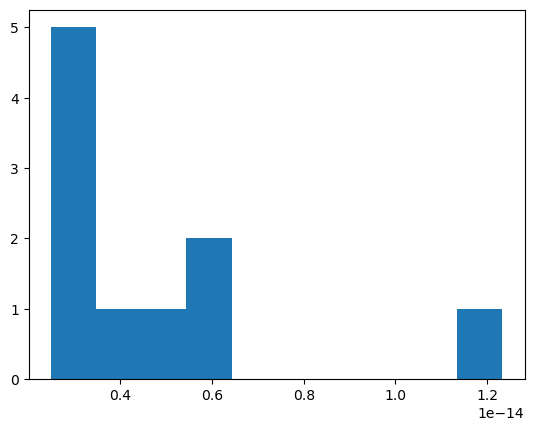

In [76]:
# OMP-PKS: Precision较低, 因为没有硬阈值.
Results = test(Y,X,times=10,func=OMP_PKS,Phi=A,s=50,haltingRule=None,maxIteration=50)
Errs = list(map(lambda l:l['relativeErrY'],Results))
plt.hist(Errs,10)

# Debug region

In [11]:
np.argmax(np.abs([1,2,-3]))

2

In [12]:
1 not in [1,2]

False

In [59]:
np.linalg.lstsq([[1,2],[3,4]],np.array([1,2]))

C:\Users\xndliu\AppData\Local\Temp\ipykernel_1040\3024612011.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  np.linalg.lstsq([[1,2],[3,4]],np.array([1,2]))


(array([0. , 0.5]),
 array([], dtype=float64),
 2,
 array([5.4649857 , 0.36596619]))